In [11]:
import sunpy 
import sunpy.map 
from sunpy.map import (make_fitswcs_header, all_coordinates_from_map,
                make_heliographic_header)
from sunpy.coordinates import (get_horizons_coord, get_earth,
        SphericalScreen, propagate_with_solar_surface)
from sunpy.visualization.wcsaxes_compat import wcsaxes_heliographic_overlay
from sunpy.visualization.drawing import limb
from map_coalign import MapSequenceCoalign
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from matplotlib import patches
from matplotlib.transforms import Affine2D
from matplotlib.legend_handler import HandlerBase, HandlerPatch
import matplotlib.patheffects as path_effects
import numpy as np
import astropy 
import astropy.units as u 
import astropy.constants as const 
from astropy.time import Time 
from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
from tqdm.notebook import tqdm
from copy import deepcopy
from glob import glob 
from scipy.ndimage import affine_transform

In [12]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pathlib import Path

font_paths = ['/cluster/home/zhuyin/scripts/fonts/xkcd-script.ttf',
              ]  # your font file path

for font_path in font_paths:
    fm.fontManager.addfont(str(font_path))

    # 2. (Re)load the font manager to update cache
    # Use the private _load_fontmanager method with try_read_cache=False
    fm.fontManager = fm.FontManager()  # rebuild programmatically
    # Alternatively:
    # fm._load_fontmanager(try_read_cache=False)  # if available

In [13]:
# a dark mode style
dm_fc = "#F3F4F3"
dm_bg = "#2D2F34"
ms_dm_style_dict = {'font.weight': 'light',
                    'font.family': ['xkcd Script',],
                    'font.size': 14,
                    # 'axes.linewidth': 1.5,
                    'lines.linewidth': 2.0,
                    'path.sketch': (1, 100, 2),
                    # 'path.effects': [path_effects.Stroke(linewidth=4, foreground='w')],
                    'grid.linewidth': 0.0,
                    'axes.grid': False, 
                    'axes.unicode_minus': False,
                    # 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                    # 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                    # 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                    # 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                    'xtick.top': False, 'ytick.right': False,
                    'ytick.left': False, 'xtick.bottom': False,
                    'xtick.direction': 'in', 'ytick.direction': 'in',
                    'lines.color': dm_fc, 'patch.edgecolor': dm_fc,
                    'text.color': dm_fc, 'axes.facecolor': dm_bg,
                    'axes.edgecolor': dm_fc, 'axes.labelcolor': dm_fc,
                    'axes.prop_cycle': plt.cycler(color=['#8dd3c7', '#feffb3', '#bfbbd9',
                    '#fa8174', '#81b1d2', '#fdb462', '#b3de69', '#bc82bd', '#ccebc4', '#ffed6f']),
                    'xtick.color': dm_fc, 'ytick.color': dm_fc,
                    'grid.color': dm_fc,
                    # 'figure.facecolor': dm_bg, 'figure.edgecolor': dm_bg,
                    # 'savefig.facecolor': dm_bg, 'savefig.edgecolor': dm_bg,
                    'figure.facecolor': "none", 'figure.edgecolor': "none",
                    'savefig.facecolor': "none", 'savefig.edgecolor': "none", 'savefig.transparent': True,
                    'axes.facecolor': "none", #'axes.edgecolor': "none",
                    'boxplot.boxprops.color': dm_fc,
                    'boxplot.capprops.color': dm_fc,
                    'boxplot.whiskerprops.color': dm_fc,
                    'boxplot.flierprops.color': dm_fc,
                    'boxplot.flierprops.markeredgecolor': dm_fc,} 

ms_dm_style_anim = ms_dm_style_dict.copy()

# Override transparency for MP4 animations
ms_dm_style_anim.update({
    'figure.facecolor': dm_bg,
    'figure.edgecolor': dm_bg,
    'savefig.facecolor': dm_bg,
    'savefig.edgecolor': dm_bg,
    'savefig.transparent': False,
    'axes.facecolor': dm_bg,
})

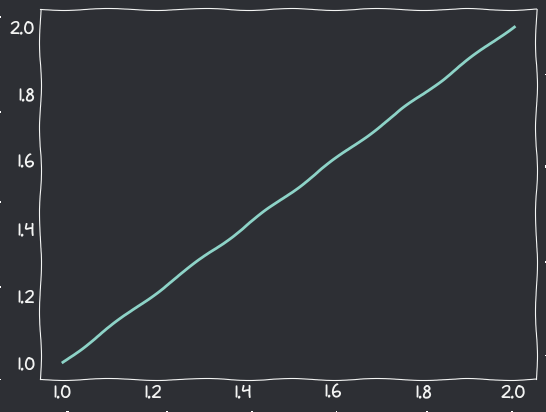

In [14]:
with plt.style.context(ms_dm_style_anim):
    plt.plot([1,2],[1,2])

In [15]:
aia_171_full = sunpy.map.Map("../data/aia/full_fov/aia.lev1_euv_12s.2012-01-27T000018Z.171.image.fits")
aia_94_full = sunpy.map.Map("../data/aia/full_fov/aia.lev1_euv_12s.2012-01-27T000006Z.94.image.fits")

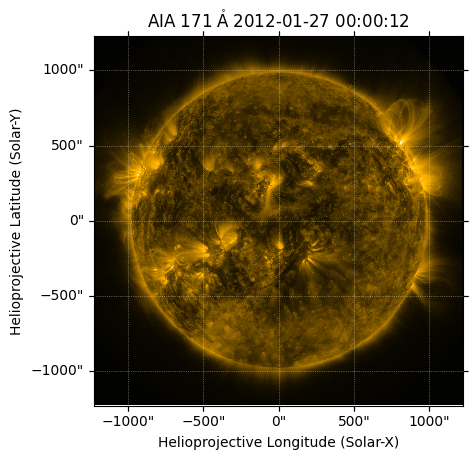

In [16]:
aia_171_full.plot()

In [17]:
def get_scale_factor(aia_map, params=None):
    hpc_coords = all_coordinates_from_map(aia_map)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / aia_map.rsun_obs

    if params is None:
        rsun_step_size = 0.01
        rsun_array = np.arange(1, r.max(), rsun_step_size)
        y = np.array([aia_map.data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
                    for this_r in rsun_array])
        
        params = np.polyfit(rsun_array[rsun_array < 1.5],
                        np.log(y[rsun_array < 1.5]), 1)
    
    scale_factor = np.exp((r-1)*-params[0])
    scale_factor[r < 1] = 1

    return params, scale_factor

In [18]:
scale_params_171, scale_factor_171_full = get_scale_factor(aia_171_full)

In [19]:
aia_171_full_data_enhanced = aia_171_full.data * scale_factor_171_full

In [20]:
aia_171_cutout_files = sorted(glob("../data/aia/171/*.fits"))
aia_94_cutout_files = sorted(glob("../data/aia/94/*.fits"))

In [21]:
aia_171_seq = sunpy.map.Map(aia_171_cutout_files, sequence=True)
aia_94_seq = sunpy.map.Map(aia_94_cutout_files, sequence=True)

In [22]:
aia_171_seq_data = aia_171_seq.data

In [23]:
_, scale_factor_171_seq = get_scale_factor(aia_171_seq[0], scale_params_171)

In [24]:
aia_171_seq_data_enhanced = aia_171_seq_data * scale_factor_171_seq[:,:,np.newaxis]
aia_171_seq_data_enhanced = np.rot90(aia_171_seq_data_enhanced, k=3, axes=(0, 1))

In [25]:
aia_94_seq_data = aia_94_seq.data
aia_94_seq_data = np.rot90(aia_94_seq_data, k=3, axes=(0, 1))

In [26]:
def norm_aia_94_to_rgba(aia_94_data, alpha_max = 0.7):
    norm = ImageNormalize(
        vmin=np.nanpercentile(aia_94_full.data, 1),
        vmax=np.nanpercentile(aia_94_full.data, 99.5),
        stretch=AsinhStretch(0.05),
        clip=True)
    
    red_channel = norm(aia_94_data)
    rgba = np.zeros((aia_94_data.shape[0], aia_94_data.shape[1], 4, aia_94_seq_data.shape[-1]))
    rgba[:, :, 0, :] = red_channel*232/255
    rgba[:, :, 1, :] = red_channel*48/255
    rgba[:, :, 2, :] = red_channel*21/255
    rgba[:, :, 3, :] = alpha_max*red_channel
    return rgba

In [27]:
aia_94_seq_data_rgba = norm_aia_94_to_rgba(aia_94_seq_data, alpha_max=0.7)

In [28]:
aia_zoom_x_start, aia_zoom_y_start = aia_171_full.wcs.world_to_pixel(aia_171_seq[0].bottom_left_coord)
aia_zoom_x_end, aia_zoom_y_end = aia_171_full.wcs.world_to_pixel(aia_171_seq[0].top_right_coord)

aia_zoom_x_center, aia_zoom_y_center = aia_171_full.wcs.world_to_pixel(aia_171_seq[0].center)

In [29]:
# fade out the text for the first 30 frames
frame_1_start = 0
frame_1_length = 30
frame_1_end = frame_1_start + frame_1_length - 1

# fade in and out the explaination texts

frame_2_start = frame_1_end + 1
frame_2_length = 100
frame_2_end = frame_2_start + frame_2_length - 1

# show the aia image 
frame_3_start = frame_2_end + 1
frame_3_length = 20
frame_3_end = frame_3_start + frame_3_length - 1

# zoom in the aia FOV

frame_4_start = frame_3_end + 1
frame_4_length = 45
frame_4_end = frame_4_start + frame_4_length - 1

# show initial configuration annotations

frame_5_start = frame_4_end + 1
frame_5_length = 120
frame_5_end = frame_5_start + frame_5_length - 1

# play the aia 171 cutout movie

frame_6_start = frame_5_end + 1
frame_6_length = aia_171_seq_data_enhanced.shape[-1]
frame_6_end = frame_6_start + frame_6_length - 1

In [30]:
aia_171_seq_0_rotate = aia_171_seq[0].rotate(90*u.deg)

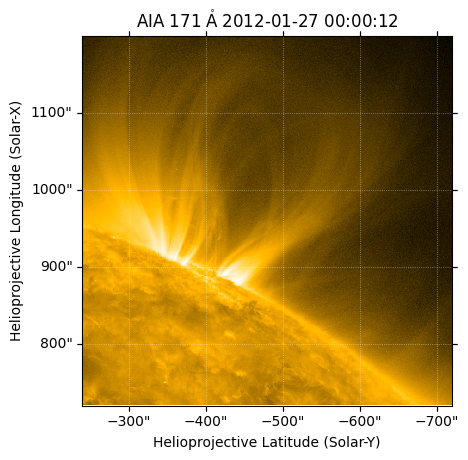

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=aia_171_seq_0_rotate.wcs)
aia_171_seq_0_rotate.plot(axes=ax)

In [32]:
aia_171_seq_0_rotate.data.shape

(800, 800)

In [33]:
ny_full, nx_full = aia_171_full.data.shape
ny_cutout, nx_cutout = aia_171_seq_0_rotate.data.shape

  0%|          | 0/734 [00:00<?, ?it/s]

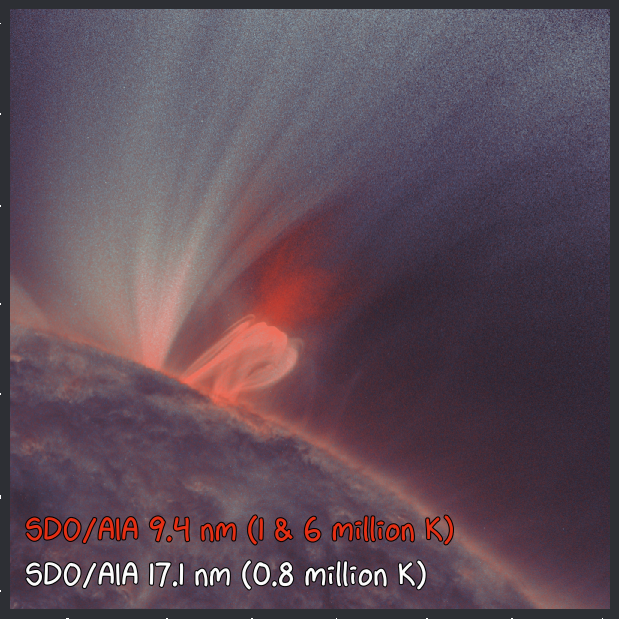

In [34]:
def make_video_part1():

    with plt.style.context(ms_dm_style_anim):
        fig = plt.figure(figsize=(6,6))
        ax_bg = fig.add_axes([0,0,1,1])
        ax_bg.set_axis_off()
        ax_im = fig.add_axes([0,0,1,1])
        ax_im.set_axis_off()

        
        text1 = ax_bg.text(0.5,0.7, "Standard Flare Model Example", va="center", ha="center", 
        fontsize=28)
        text2 = ax_bg.text(0.5,0.6, "Data Courtesy of\nNASA/SDO\nAIA\nSTEREO Teams\nand\nSECCHI Consortium\n\nReference\nSun+2015, NatCom, 6, 7598",
        va="top", ha="center", fontsize=18, linespacing=1.5)

        text_list = [text1, text2]
        annot_list = []
        im_list = []
        
        # plt.show()

        def update_frame(ii):
            nonlocal text_list, fig, ax_bg, im_list, ax_im, annot_list

            if ii <= frame_1_end:
                progress = (ii - frame_1_start + 1) / frame_1_length
                for t in text_list:
                    t.set_alpha(1 - progress)
            
            if ii == frame_2_start:
                for text_ in text_list:
                    text_.remove()
                text3 = ax_bg.text(0.5,0.5, 
                'This video shows a solar flare\n'
                'with a morphology similar to the\n'
                '2D "Standard Flare Model",\n'
                'which might be helpful for\n'
                'interpreting the cartoons.\n'
                'In reality, flare reconnection\n'
                'occurs in 3D and is related to\n'
                'complex topological changes in\n'
                'the coronal magnetic field.',
                va="center", ha="center",
                linespacing=1.4,
                fontsize=28)
                text3.set_alpha(0)
                text_list.append(text3)
            
            if frame_2_start < ii <= frame_2_end:
                fade_in = 25
                fade_out = 25
                
                if ii < frame_2_start + fade_in:
                    progress = (ii - frame_2_start + 1) / fade_in
                elif ii > frame_2_end - fade_out:
                    progress = (frame_2_end - ii) / fade_out
                else:
                    progress = 1
                text_list[-1].set_alpha(progress)
            
            if ii == frame_3_start:
                text_list[-1].remove()
                im = ax_im.imshow(aia_171_full_data_enhanced,
                    cmap="bone", interpolation="none",
                    origin="lower",
                    norm=ImageNormalize(
                        vmin=np.nanpercentile(aia_171_full_data_enhanced, 1),
                        vmax=np.nanpercentile(aia_171_full_data_enhanced, 99.5),
                        stretch=AsinhStretch(),
                    ))
                
                im.set_alpha(0)
                im_list.append(im)
            
            if frame_3_start < ii <= frame_3_end:
                progress = (ii - frame_3_start + 1) / frame_3_length
                im_list[0].set_alpha(progress)

            if ii == frame_4_start:
                im_list[0].remove()
                ax_im.clear()
                im = ax_im.imshow(np.zeros((ny_cutout, nx_cutout)),
                    cmap="bone", interpolation="none",
                    origin="lower",
                    norm=ImageNormalize(
                        vmin=np.nanpercentile(aia_171_full_data_enhanced, 1),
                        vmax=np.nanpercentile(aia_171_full_data_enhanced, 99.5),
                        stretch=AsinhStretch(),
                    ))
                
                im_list.append(im)
                ax_im.set_axis_off()
            
            if frame_4_start <= ii <=frame_4_end:
                progress = (ii - frame_4_start) / (frame_4_length - 1)

                ease = 3*progress**2 - 2*progress**3
                

                # x_starts = 4096 * 0.0 + (aia_zoom_x_start - 0.0) * ease
                # x_ends = 4096 * 1.0 + (aia_zoom_x_end - 4096) * ease
                # y_starts = 4096 * 0.0 + (aia_zoom_y_start - 0.0) * ease
                # y_ends = 4096 * 1.0 + (aia_zoom_y_end - 4096) * ease

                # ax_im.set_xlim(x_starts, x_ends)
                # ax_im.set_ylim(y_starts, y_ends)            

                final_rotation = 90
                angle = np.deg2rad(final_rotation)*ease
                scale = 1.0 + (nx_full/nx_cutout - 1.0)*(1 - ease)

                cx_t = nx_full/2 + (aia_zoom_x_center - nx_full/2)*ease
                cy_t = ny_full/2 + (aia_zoom_y_center - ny_full/2)*ease


                cos_a, sin_a = np.cos(angle), np.sin(angle)
        
                # Rotation + scaling matrix
                matrix = np.array([
                    [cos_a*scale, -sin_a*scale],
                    [sin_a*scale,  cos_a*scale]
                ])

                output_center = np.array([ny_cutout / 2, nx_cutout / 2])
                input_center = np.array([cy_t, cx_t])
                offset = input_center - matrix @ output_center
        
                # Apply affine transform
                transformed = affine_transform(aia_171_full_data_enhanced, matrix, offset=offset,
                                            output_shape=(ny_cutout, nx_cutout),
                                            order=3, mode='constant', cval=0)
        
                im_list[-1].set_data(transformed)
            
            # show initial configuration annotations
            if ii == frame_5_start:
                annot1 = ax_im.annotate("Anti-parallel\nloops", xy=(320, 320),
                xytext=(310, 130), arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=0,
                path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                ),
                va="center", ha="center", fontsize=24,
                path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                alpha=0)

                annot2 = ax_im.annotate("Anti-parallel\nloops", xy=(250, 350),
                xytext=(310, 130), arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3,rad=-0.5",facecolor="w", lw=1.5, alpha=0,
                path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
                va="center", ha="center", fontsize=24, alpha=0)

                annot3 = ax_im.annotate("Dark cavity\n(Flux rope)", xy=(400, 500),
                xytext=(580, 480), arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=0,
                path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
                va="center", ha="center", fontsize=24,
                path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                alpha=0)

                # annot_list[0]: anti-parallel loop
                annot_list.append(annot1)
                # annot_list[1]: another arrow for anti-parallel loop
                annot_list.append(annot2)
                # annot_list[2]: dark cavity
                annot_list.append(annot3)

                text4 = ax_im.text(20, 20, r"SDO/AIA 17.1 nm (0.8 million K)",
                    color="w", ha="left", va="bottom", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)
                
                text_list.append(text4)

            if frame_5_start < ii <= frame_5_end:
                fade_in = 25
                fade_out = 25
                
                if ii < frame_5_start + fade_in:
                    progress = (ii - frame_5_start) / fade_in
                elif ii > frame_5_end - fade_out:
                    progress = (frame_5_end - ii) / fade_out
                else:
                    progress = 1
                
                annot_list[0].set_alpha(progress)
                annot_list[0].arrow_patch.set_alpha(progress)
                annot_list[1].arrow_patch.set_alpha(progress)
                annot_list[2].set_alpha(progress)
                annot_list[2].arrow_patch.set_alpha(progress)
            
            if ii == frame_6_start:
                for annot in annot_list:
                    annot.remove()
            
            if frame_6_start <= ii <= frame_6_end:
                # commented for faster rendering
                # im_list[1] is for AIA 171
                im_list[1].set_data(aia_171_seq_data_enhanced[:,:,ii - frame_6_start])

                fade_in = 10
                fade_out = 10
                stay = 30

                rope_rise_index = 120
                if ii == rope_rise_index + frame_6_start:
                    text_rope_rise = ax_im.text(420, 550, "Flux rope rises",
                    color="w", ha="center", va="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    rotation=-30, alpha=0)

                    annot_rope_rise = ax_im.annotate("", xy=(450+100*0.5, 580+100*np.sqrt(3)/3),
                    xytext=(450, 580), arrowprops=dict(arrowstyle="->",
                    facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ), 
                    va="center", ha="center")
                    
                    # text_list[4]: "Flux rope rises"
                    text_list.append(text_rope_rise)
                    # annot_list[3]: arrow for flux rope rise
                    annot_list.append(annot_rope_rise)
                
                if rope_rise_index + frame_6_start < ii <= rope_rise_index + frame_6_start + fade_in:
                    progress = (ii - (rope_rise_index + frame_6_start)) / fade_in
                    text_list[4].set_alpha(progress)
                    annot_list[3].arrow_patch.set_alpha(progress)
                elif rope_rise_index + frame_6_start + fade_in + stay <= ii <= rope_rise_index + frame_6_start + fade_in + stay + fade_out:
                    progress = 1 - (ii - (rope_rise_index + frame_6_start + fade_in + stay)) / fade_out
                    text_list[4].set_alpha(progress)
                    annot_list[3].arrow_patch.set_alpha(progress)
                elif ii == rope_rise_index + frame_6_start + fade_in + stay + fade_out + 1:
                    text_list[4].remove()
                    annot_list[3].remove()

                loop_app_index = 150
                if ii == loop_app_index + frame_6_start:
                    annot_loop_app_1 = ax_im.annotate("",
                    xy=(350, 320), xytext=(350+80*np.cos(np.deg2rad(25)), 320-80*np.sin(np.deg2rad(25))), arrowprops=dict(arrowstyle="->",
                    facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ), 
                    va="center", ha="center")

                    annot_loop_app_2 = ax_im.annotate("",
                    xy=(350 - 100*np.cos(np.deg2rad(25)), 320 + 100*np.sin(np.deg2rad(25))),
                    xytext=(350 - 100*np.cos(np.deg2rad(25)) - 80*np.cos(np.deg2rad(25)),
                    320 + 100*np.sin(np.deg2rad(25)) + 80*np.sin(np.deg2rad(25))), arrowprops=dict(arrowstyle="->",
                    facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ), 
                    va="center", ha="center")

                    text_loop_app = ax_im.text(260, 250, "Opposite polarities\napproaches",
                    color="w", ha="center", va="center", fontsize=24, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    rotation=-25)
                
                    # text_list[5]: "Opposite polarities approaches"
                    text_list.append(text_loop_app)
                    # annot_list[4:6]: arrow for flux rope rise
                    annot_list.append(annot_loop_app_1)
                    annot_list.append(annot_loop_app_2)
                
                if loop_app_index + frame_6_start < ii <= loop_app_index + frame_6_start + fade_in:
                    progress = (ii - (loop_app_index + frame_6_start)) / fade_in
                    text_list[5].set_alpha(progress)
                    annot_list[4].arrow_patch.set_alpha(progress)
                    annot_list[5].arrow_patch.set_alpha(progress)
                elif loop_app_index + frame_6_start + fade_in + stay <= ii <= loop_app_index + frame_6_start + fade_in + stay + fade_out:
                    progress = 1 - (ii - (loop_app_index + frame_6_start + fade_in + stay)) / fade_out
                    text_list[5].set_alpha(progress)
                    annot_list[4].arrow_patch.set_alpha(progress)
                    annot_list[5].arrow_patch.set_alpha(progress)
                elif ii == loop_app_index + frame_6_start + fade_in + stay + fade_out + 1:
                    text_list[5].remove()
                    annot_list[4].remove()
                    annot_list[5].remove()
                
                xpoint_index = 200
                if ii == xpoint_index + frame_6_start:
                    annot_x_point = ax_im.annotate("Reconnection site",
                        xy=(370, 400), xytext=(480, 300), arrowprops=dict(arrowstyle="->",
                        facecolor="w", lw=1.5, connectionstyle="arc3,rad=0.3", alpha=0,
                        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                        ), 
                        va="center", ha="center", fontsize=24, alpha=0,
                        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)
                    
                    # annot_list[6]: arrow for x point
                    annot_list.append(annot_x_point)
                
                if xpoint_index + frame_6_start < ii <= xpoint_index + frame_6_start + fade_in:
                    progress = (ii - (xpoint_index + frame_6_start)) / fade_in
                    annot_list[6].set_alpha(progress)
                    annot_list[6].arrow_patch.set_alpha(progress)
                elif xpoint_index + frame_6_start + fade_in + stay <= ii <= xpoint_index + frame_6_start + fade_in + stay + fade_out:
                    progress = 1 - (ii - (xpoint_index + frame_6_start + fade_in + stay)) / fade_out
                    annot_list[6].set_alpha(progress)
                    annot_list[6].arrow_patch.set_alpha(progress)
                elif ii == xpoint_index + frame_6_start + fade_in + stay + fade_out + 1:
                    annot_list[6].remove()

                show_aia_94_index = 210
                if ii == show_aia_94_index + frame_6_start:
                    im_94 = ax_im.imshow(aia_94_seq_data_rgba[:,:,:,ii - frame_6_start],origin="lower", zorder=2, alpha=0)
                    # im_list[2] is for AIA 94
                    im_list.append(im_94)

                    text_aia_94 = ax_im.text(20, 80, r"SDO/AIA 9.4 nm (1 & 6 million K)",
                        color="#E83015", ha="left", va="bottom", alpha=0, fontsize=24,
                        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)
                    
                    # text_list[6]: "SDO/AIA 9.4 nm (1 & 6 million K)"
                    text_list.append(text_aia_94)
                
                if ii > show_aia_94_index + frame_6_start:
                    if ii <= show_aia_94_index + frame_6_start + fade_in:
                        progress = (ii - (show_aia_94_index + frame_6_start)) / fade_in
                        im_list[2].set_alpha(progress)
                        text_list[6].set_alpha(progress*0.8)
                    im_list[2].set_data(aia_94_seq_data_rgba[:,:,:,ii - frame_6_start])

                pfl_index = 320
                if ii == pfl_index + frame_6_start:
                    annot_pfl = ax_im.annotate("Post-flare loops",
                        xy=(380, 320), xytext=(480, 220), arrowprops=dict(arrowstyle="->",
                        facecolor="w", lw=1.5, connectionstyle="arc3,rad=0.4", alpha=0,
                        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                        ), 
                        va="center", ha="center", fontsize=24, alpha=0,
                        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)
                    
                    # annot_list[7]: arrow for post-flare loops
                    annot_list.append(annot_pfl)
                
                if pfl_index + frame_6_start < ii <= pfl_index + frame_6_start + fade_in:
                    progress = (ii - (pfl_index + frame_6_start)) / fade_in
                    annot_list[7].set_alpha(progress)
                    annot_list[7].arrow_patch.set_alpha(progress)
                elif pfl_index + frame_6_start + fade_in + stay <= ii <= pfl_index + frame_6_start + fade_in + stay + fade_out:
                    progress = 1 - (ii - (pfl_index + frame_6_start + fade_in + stay)) / fade_out
                    annot_list[7].set_alpha(progress)
                    annot_list[7].arrow_patch.set_alpha(progress)
                elif ii == pfl_index + frame_6_start + fade_in + stay + fade_out + 1:
                    annot_list[7].remove()
                

        anim = animation.FuncAnimation(fig, update_frame,
        frames=tqdm(range(frame_6_end)), blit=False)
        anim.save("../figs/movies/standard_flare_model_part1.mp4", fps=15, dpi=150,writer='ffmpeg', 
        codec='libx264',
        # bitrate=400, # turn on for tests
        extra_args=['-pix_fmt', 'yuv420p',
        '-vf', 'crop=880:880:10:10,pad=ceil(iw/2)*2:ceil(ih/2)*2'])



make_video_part1()

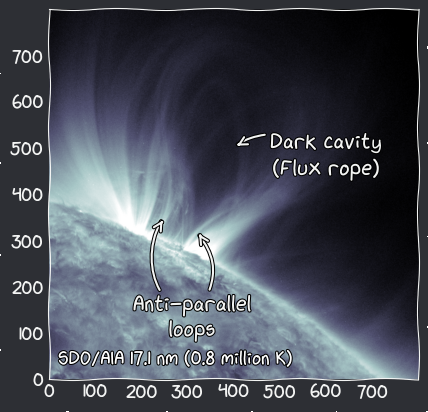

In [35]:
with plt.style.context(ms_dm_style_anim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(aia_171_seq_0_rotate.data,
    norm=ImageNormalize(
        vmin=np.nanpercentile(aia_171_seq_0_rotate.data, 1),
        vmax=np.nanpercentile(aia_171_seq_0_rotate.data, 99.5),
        stretch=AsinhStretch(0.05)),
        origin="lower",
        cmap="bone",
    )

    annot1 = ax.annotate("Anti-parallel\nloops", xy=(320, 320),
    xytext=(310, 130), arrowprops=dict(arrowstyle="->",
    connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ),
    va="center", ha="center", fontsize=16,
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    annot2 = ax.annotate("Anti-parallel\nloops", xy=(250, 350),
    xytext=(310, 130), arrowprops=dict(arrowstyle="->",
    connectionstyle="arc3,rad=-0.5",facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
    va="center", ha="center", fontsize=16, alpha=0)

    annot3 = ax.annotate("Dark cavity\n(Flux rope)", xy=(400, 500),
    xytext=(600, 480), arrowprops=dict(arrowstyle="->",
    connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
    va="center", ha="center", fontsize=16,
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    ax.text(20, 20, r"SDO/AIA 17.1 nm (0.8 million K)",
    color="w", ha="left", va="bottom",
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    # annot3.set_alpha(0)
    # annot3.arrow_patch.set_alpha(0)
    # annot3.remove()

    fig.savefig("../figs/test_frames/annotation.png")

In [36]:
aia_171_seq[220].date

<Time object: scale='utc' format='isot' value=2012-01-27T03:40:12.345>

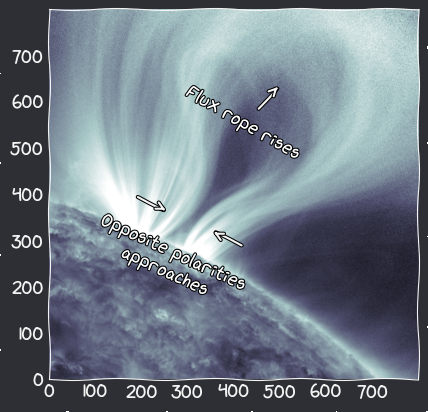

In [37]:
with plt.style.context(ms_dm_style_anim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(aia_171_seq_data_enhanced[:,:,150],
    norm=ImageNormalize(
        vmin=np.nanpercentile(aia_171_seq_0_rotate.data, 1),
        vmax=np.nanpercentile(aia_171_seq_0_rotate.data, 99.5),
        stretch=AsinhStretch()),
        origin="lower",
        cmap="bone",
    )

    text_rope_rise = ax.text(420, 550, "Flux rope rises",
    color="w", ha="center", va="center",
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
    rotation=-30)

    annot_rope_rise = ax.annotate("", xy=(450+100*0.5, 580+100*np.sqrt(3)/3),
    xytext=(450, 580), arrowprops=dict(arrowstyle="->",
    facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ), 
    va="center", ha="center")

    annot_loop_app_1 = ax.annotate("",
    xy=(350, 320), xytext=(350+80*np.cos(np.deg2rad(25)), 320-80*np.sin(np.deg2rad(25))), arrowprops=dict(arrowstyle="->",
    facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ), 
    va="center", ha="center")

    annot_loop_app_2 = ax.annotate("",
    xy=(350 - 100*np.cos(np.deg2rad(25)), 320 + 100*np.sin(np.deg2rad(25))),
    xytext=(350 - 100*np.cos(np.deg2rad(25)) - 80*np.cos(np.deg2rad(25)),
    320 + 100*np.sin(np.deg2rad(25)) + 80*np.sin(np.deg2rad(25))), arrowprops=dict(arrowstyle="->",
    facecolor="w", lw=1.5,
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ), 
    va="center", ha="center")

    text_loop_app = ax.text(260, 250, "Opposite polarities\napproaches",
    color="w", ha="center", va="center",
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
    rotation=-25)

    # annot3.set_alpha(0)
    # annot3.arrow_patch.set_alpha(0)
    # annot3.remove()

    fig.savefig("../figs/test_frames/annotation.png")

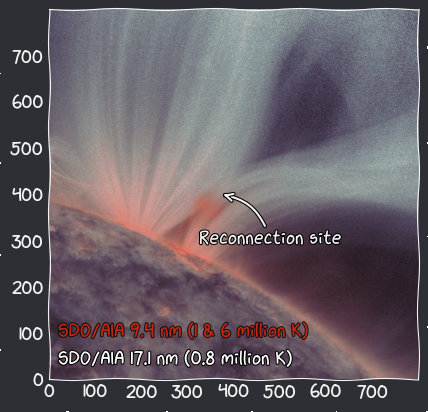

In [38]:
with plt.style.context(ms_dm_style_anim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(aia_171_seq_data_enhanced[:,:,220],
    norm=ImageNormalize(
        vmin=np.nanpercentile(aia_171_seq_0_rotate.data, 1),
        vmax=np.nanpercentile(aia_171_seq_0_rotate.data, 99.5),
        stretch=AsinhStretch()),
        origin="lower",
        cmap="bone",
        alpha=1,
    )

    annot_x_point = ax.annotate("Reconnection site",
    xy=(370, 400), xytext=(480, 300), arrowprops=dict(arrowstyle="->",
    facecolor="w", lw=1.5, connectionstyle="arc3,rad=0.3",
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ), 
    va="center", ha="center",
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    im_94 =ax.imshow(aia_94_seq_data_rgba[:,:,:,220],origin="lower", zorder=2)
    im_94.set_alpha(1)

    ax.text(20, 20, r"SDO/AIA 17.1 nm (0.8 million K)",
        color="w", ha="left", va="bottom",
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    ax.text(20, 80, r"SDO/AIA 9.4 nm (1 & 6 million K)",
        color="#E83015", ha="left", va="bottom", alpha=0.8,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

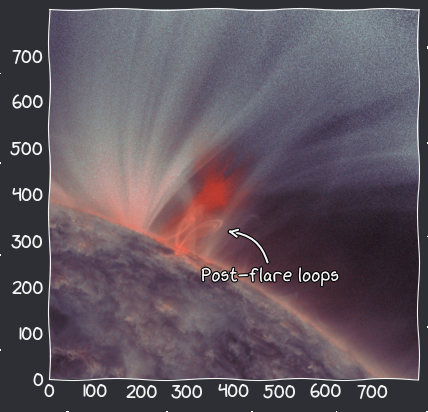

In [39]:
with plt.style.context(ms_dm_style_anim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(aia_171_seq_data_enhanced[:,:,320],
    norm=ImageNormalize(
        vmin=np.nanpercentile(aia_171_seq_0_rotate.data, 1),
        vmax=np.nanpercentile(aia_171_seq_0_rotate.data, 99.5),
        stretch=AsinhStretch()),
        origin="lower",
        cmap="bone",
        alpha=1,
    )

    annot_pfl = ax.annotate("Post-flare loops",
    xy=(380, 320), xytext=(480, 220), arrowprops=dict(arrowstyle="->",
    facecolor="w", lw=1.5, connectionstyle="arc3,rad=0.4",
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
    ), 
    va="center", ha="center",
    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],)

    ax.imshow(aia_94_seq_data_rgba[:,:,:,320],origin="lower", zorder=1)

In [40]:
def set_axis_alpha(ax, alpha):
    spines = [ax.spines['bottom'], ax.spines['left'], ax.spines['top'], ax.spines['right']]
    for spine in spines:
        spine.set_alpha(alpha)
    
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_alpha(alpha)
            
    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tick.tick1line.set_alpha(alpha)
        tick.tick2line.set_alpha(alpha)
    
    ax.xaxis.label.set_alpha(alpha)
    ax.yaxis.label.set_alpha(alpha)

    # Patches (circles, rectangles, polygons, etc.)
    for patch in ax.patches:
        patch.set_alpha(alpha)
    
    # Legend
    legend = ax.get_legend()
    if legend is not None:
        legend.set_alpha(alpha)
        # Also set alpha for legend frame and texts
        legend.get_frame().set_alpha(alpha)
        for text in legend.get_texts():
            text.set_alpha(alpha)
        # Legend handles (the colored patches/lines in the legend)
        for handle in legend.legend_handles:
            handle.set_alpha(alpha)
    
    # Annotations
    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Annotation):
            child.set_alpha(alpha)
            # Also set alpha for the arrow if it exists
            if child.arrow_patch is not None:
                child.arrow_patch.set_alpha(alpha)

In [41]:
secchi_files = sorted(glob("../data/secchi/171/*.fts"))

In [42]:
secchi_map_seq = MapSequenceCoalign(sunpy.map.Map(secchi_files, sequence=False))

In [56]:
secchi_map_cutout_seq = secchi_map_seq.submap(bottom_left=(650, 500)*u.pix, top_right=(1050-1, 900-1)*u.pix)

secchi_map_cutout_seq = [secchi_map_cutout_seq[0]]
with propagate_with_solar_surface():
    for ii in range(1, len(secchi_files)):
        secchi_map_cutout_seq.append(secchi_map_seq[ii].reproject_to(secchi_map_cutout_seq[0].wcs))

secchi_map_cutout_seq = MapSequenceCoalign(secchi_map_cutout_seq)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [57]:
secchi_map_cutout_data = secchi_map_cutout_seq.data

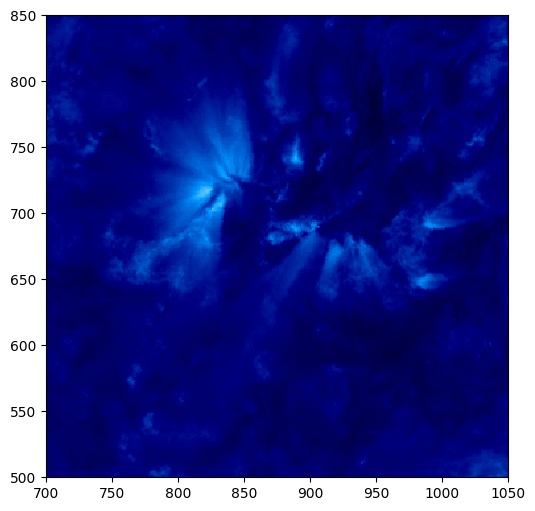

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(secchi_map_seq[1].data, **secchi_map_seq[0].plot_settings)
ax.set_xlim(700, 1050)
ax.set_ylim(500, 850)
plt.show()

In [63]:
# frame 7 is in part 2 so start from 0
# fade in the out for the explaination texts

frame_7_start = 0
frame_7_length = 100
frame_7_end = frame_7_start + frame_7_length - 1

# show the positions of earth and stereo
frame_8_start = frame_7_end + 1
frame_8_length = 125
frame_8_end = frame_8_start + frame_8_length - 1

# fade in secchi image
frame_9_start = frame_8_end + 1
frame_9_length = 25
frame_9_end = frame_9_start + frame_9_length - 1

# show annotation for anti-parallel loops 
frame_10_start = frame_9_end + 1
frame_10_length = 80
frame_10_end = frame_10_start + frame_10_length - 1

# play scenes 
frame_11_start = frame_10_end + 1
frame_11_length = 140
frame_11_end = frame_11_start + frame_11_length - 1

# show used packages 
frame_12_start = frame_11_end + 1
frame_12_length = 50
frame_12_end = frame_12_start + frame_12_length - 1

In [47]:
hg_lat_interp = np.linspace(aia_171_full.observer_coordinate.lat,
                            secchi_map_seq[0].observer_coordinate.lat,
                            frame_8_length - 25*3)
hg_lon_interp = np.linspace(aia_171_full.observer_coordinate.lon,
                            secchi_map_seq[0].observer_coordinate.lon,
                            frame_8_length - 25*3)
hg_radius_interp = np.linspace(aia_171_full.observer_coordinate.radius,
                                secchi_map_seq[0].observer_coordinate.radius,
                                frame_8_length - 25*3)

transit_observer = SkyCoord(
    lon=hg_lon_interp,
    lat=hg_lat_interp,
    radius=hg_radius_interp,
    frame="heliographic_stonyhurst",
    observer="self",
    obstime=aia_171_full.date
)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [48]:
class VideoCameraIcon:
    """A video camera icon |>[ ] made of matplotlib patches with FOV indicator"""
    def __init__(self, ax, x=0, y=0, size=1, angle=0, fov_angle=60, fov_length=3, fov_alpha=0.2):
        self.ax = ax
        self.x = x
        self.y = y
        self.size = size
        self.angle = angle
        self.fov_angle = fov_angle
        self.fov_length = fov_length
        self.fov_alpha = fov_alpha
        
        # Camera body dimensions
        body_width = 1.2
        body_height = 0.6
        
        # Center the camera body at origin (before transformation)
        # Body centered: left edge at -body_width/2, bottom at -body_height/2
        self.body = patches.FancyBboxPatch(
            (-body_width/2, -body_height/2), body_width, body_height, 
            boxstyle="round,pad=0.08",
            facecolor='white',
            edgecolor='white',
            linewidth=3
        )
        
        # Triangle (lens) - positioned relative to centered body
        # Right edge of body is at body_width/2
        tip_x = body_width/2
        triangle = np.array([
            [tip_x, 0], 
            [tip_x + 0.6, body_height/2], 
            [tip_x + 0.6, -body_height/2]
        ])
        self.triangle = patches.Polygon(
            triangle,
            facecolor='white',
            edgecolor='white',
            linewidth=3,
            joinstyle='miter'
        )
        
        # Create the FOV triangle
        self.fov = self._create_fov_triangle()
        
        # Add all patches to the axis (FOV first so it's behind the camera)
        self.patches_list = [self.fov, self.body, self.triangle]
        for patch in self.patches_list:
            ax.add_patch(patch)
        
        # Apply initial transform
        self.update_transform()
    
    def _create_fov_triangle(self):
        """Create the FOV triangle based on fov_angle and fov_length"""
        # Start from the tip of the lens (right edge of triangle)
        body_width = 1.0
        tip_x = 0 # body_width/2 + 0.2  # Right edge of body + triangle extension
        tip_y = 0
        
        half_angle = np.radians(self.fov_angle / 2)
        
        end_x = tip_x + self.fov_length
        upper_y = self.fov_length * np.tan(half_angle)
        lower_y = -self.fov_length * np.tan(half_angle)
        
        fov_vertices = np.array([
            [tip_x, tip_y],
            [end_x, upper_y],
            [end_x, lower_y]
        ])
        
        return patches.Polygon(
            fov_vertices,
            facecolor='#FBE251',
            edgecolor='none',
            alpha=self.fov_alpha,
            linewidth=1
        )
    
    def update_transform(self):
        """Update the position, rotation, and scale of all patches"""
        transform = (Affine2D()
                    .scale(self.size)
                    .rotate_deg(self.angle)
                    .translate(self.x, self.y)
                    + self.ax.transData)
        
        for patch in self.patches_list:
            patch.set_transform(transform)
    
    def get_position(self):
        """Get the current camera position"""
        return self.x, self.y
    
    def set_position(self, x, y):
        """Set the camera position"""
        self.x = x
        self.y = y
        self.update_transform()
    
    def set_zorder(self, zorder):
        """Update the zorder of all patches"""
        for patch in self.patches_list:
            patch.set_zorder(zorder)
        self.patches_list[0].set_zorder(zorder-1)
    
    def get_angle(self):
        """Get the current camera angle"""
        return self.angle
    
    def set_angle(self, angle):
        """Set the camera rotation angle in degrees"""
        self.angle = angle
        self.update_transform()
    
    def get_size(self):
        """Get the current camera size"""
        return self.size
    
    def set_size(self, size):
        """Set the camera size"""
        self.size = size
        self.update_transform()
    
    def set_fov_angle(self, fov_angle):
        """Set the FOV angle and recreate the FOV triangle"""
        self.fov_angle = fov_angle
        self.fov.remove()
        self.fov = self._create_fov_triangle()
        self.ax.add_patch(self.fov)
        self.patches_list[0] = self.fov
        self.update_transform()
    
    def set_fov_length(self, fov_length):
        """Set the FOV length and recreate the FOV triangle"""
        self.fov_length = fov_length
        self.fov.remove()
        self.fov = self._create_fov_triangle()
        self.ax.add_patch(self.fov)
        self.patches_list[0] = self.fov
        self.update_transform()

    def set_alpha(self, alpha):
        """Set the alpha (transparency) for all camera components
        
        Parameters
        ----------
        alpha : float
            Overall alpha value (0-1) for the camera icon.
            The FOV triangle will use alpha * self.fov_alpha to maintain relative transparency.
        """
        # Set alpha for camera body and lens triangle
        self.body.set_alpha(alpha)
        self.triangle.set_alpha(alpha)
        
        # For FOV, multiply by the original fov_alpha to keep it more transparent
        self.fov.set_alpha(alpha * self.fov_alpha)
    
    def remove(self):
        """Remove the camera from the axis"""
        for patch in self.patches_list:
            patch.remove()

In [49]:
class HandlerCircle(HandlerBase):
    """Draw a true circle in the legend handle box, preserving edge/face/ls/lw."""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # center of the handle box
        cx = xdescent + 0.5 * width
        cy = ydescent + 0.5 * height
        # radius fits the box (with small padding if you like)
        r = 0.95 * min(width, height) * orig_handle.get_radius()/0.06

        circ = patches.Circle(
            (cx, cy), r,
            transform=trans,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            linestyle=orig_handle.get_linestyle(),
            linewidth=orig_handle.get_linewidth(),
            fill=orig_handle.get_fill(),
        )
        return [circ]

In [50]:
rsun_to_au = (const.R_sun/const.au).to_value(u.dimensionless_unscaled)

  0%|          | 0/520 [00:00<?, ?it/s]

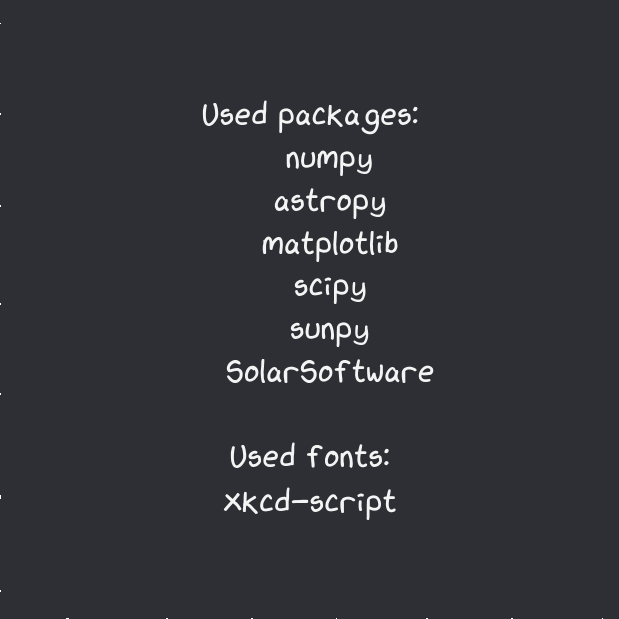

In [69]:
def make_video_part2():
    with plt.style.context(ms_dm_style_anim):
        plt.close("all")
        fig = plt.figure(figsize=(6,6))
        ax_bg = fig.add_axes([0,0,1,1])
        ax_bg.set_axis_off()
        
        ax_im = fig.add_axes([0,0,1,1])
        ax_im.set_axis_off()

        ax_hg = fig.add_axes([0.04,0.04,0.92,0.92])
        ax_hg.set_aspect(1)
        ax_hg.set_xlim(-1.1,1.1)
        ax_hg.set_ylim(1.1,-1.1)

        ax_hg.set_xticks([])
        ax_hg.set_yticks([])

        circle_sun = patches.Circle((0, 0), 15*rsun_to_au, color="orange", alpha=1,
                    label="Sun")
        
        pos_earth = aia_171_full.observer_coordinate

        circle_earth = patches.Circle((pos_earth.cartesian.y.to_value(u.au),
                                pos_earth.cartesian.x.to_value(u.au)),
                                5*rsun_to_au, color="#81C7D4", alpha=1,
                                label="Earth")
        
        pos_stereo = secchi_map_seq[0].observer_coordinate

        circle_stereo = patches.Circle((pos_stereo.cartesian.y.to_value(u.au),
                                pos_stereo.cartesian.x.to_value(u.au)),
                                5*rsun_to_au, color="#E83015", alpha=1,
                                label="STEREO-A")

        # patch_list: sun, earth, stereo
        patch_list = []

        patch_list.append(ax_hg.add_patch(circle_sun))
        patch_list.append(ax_hg.add_patch(circle_earth))
        patch_list.append(ax_hg.add_patch(circle_stereo))

        ax_hg.annotate(
        "Flare", 
        xy=(18*rsun_to_au,0),
        xytext=(28*rsun_to_au, 30*rsun_to_au),
        xycoords="data",
        arrowprops={"arrowstyle":"->",
            "connectionstyle":"arc3,rad=0.5","color":"white","lw":1.5},
        color="white", 
        fontsize=24,
        va="top",
        ha="left"
        )

        handler_map = {
            circle_sun: HandlerCircle(),
            circle_earth: HandlerCircle(),
            circle_stereo: HandlerCircle(),
        }

        ax_hg.legend([circle_sun, circle_earth, circle_stereo],
            ["Sun", "Earth", "STEREO-A"],
            handler_map=handler_map,
            frameon=False, loc="lower left", fontsize=18)

        fov_angle = 2*1300*15/3600

        icon_camera = VideoCameraIcon(
            ax_hg,
            x=pos_earth.cartesian.y.to_value(u.au),
            y=pos_earth.cartesian.x.to_value(u.au),
            size=0.05,
            angle=-90,
            fov_angle=fov_angle,
            fov_length=2.5/0.05,
            fov_alpha=0.5,
            )
        
        icon_camera.set_zorder(0)
        icon_camera.set_alpha(0)

        set_axis_alpha(ax_hg, 0)
        ax_hg.set_axis_off()

        # text_list[0]: explanation of the STEREO observation
        text0 = ax_bg.text(0.5,0.5,
            "The same flare eruption\n" 
            "from another perspective:\n"
            "STEREO-A spacecraft",
            va="center", ha="center",
            linespacing=1.5,
            fontsize=28, alpha=1, zorder=5)
        
        text_list = [text0]

        im_list = []
        annot_list = []

        def update_frame(ii):
            nonlocal text_list, fig, ax_bg, im_list, ax_im, ax_hg, annot_list, icon_camera
            fade_in = 25 
            fade_out = 25

            if ii < frame_7_end:
                if frame_7_start <= ii <= frame_7_start + fade_in:
                    progress = (ii - frame_7_start) / fade_in
                    text_list[0].set_alpha(progress)
                if frame_7_end - fade_out <= ii <= frame_7_end:
                    progress = (frame_7_end - ii) / fade_out
                    text_list[0].set_alpha(progress)
            
            if ii == frame_8_start:
                text_list[0].remove()
                ax_hg.set_axis_on()




            if frame_8_start < ii <= frame_8_start + fade_in:

                progress = (ii - frame_8_start) / fade_in
                set_axis_alpha(ax_hg, progress)
                icon_camera.set_alpha(0)
            
            if frame_8_start + fade_in < ii <= frame_8_start + 2*fade_in:
                progress = (ii - frame_8_start - fade_in) / fade_in
                icon_camera.set_alpha(progress)
            
            if frame_8_start + 2*fade_in < ii <= frame_8_end - fade_out:
                progress = ii - (frame_8_start + 2*fade_in)
                observer_x = transit_observer[progress].cartesian.x.to_value(u.au)
                observer_y = transit_observer[progress].cartesian.y.to_value(u.au)

                icon_camera.set_position(
                    observer_y, observer_x
                )

                icon_camera.set_angle(-90 - transit_observer[progress].lon.to_value(u.deg))
                icon_camera.set_zorder(0)
            
            if frame_8_end - fade_out <= ii <= frame_8_end:
                progress = (frame_8_end - ii) / fade_out
                set_axis_alpha(ax_hg, progress)
                icon_camera.set_alpha(progress)
            
            if ii == frame_9_start:
                ax_hg.clear()
                ax_hg.set_axis_off()

                im = ax_im.imshow(secchi_map_cutout_data[:,:,0],
                origin="lower",
                cmap="bone",
                norm=ImageNormalize(
                    vmin=np.nanpercentile(secchi_map_cutout_data[:,:,0], 1),
                    vmax=np.nanpercentile(secchi_map_cutout_data[:,:,0], 99.9),
                    stretch=AsinhStretch(0.05),
                ),
                alpha=0
                )

                im_list.append(im)

                text_secchi = ax_im.text(10, 10, "SECCHI/EUVI 17.1 nm (0.8 million K)",
                    fontsize=24, va="bottom", ha="left", alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
                
                # text_list[1] is for secchi

                text_list.append(text_secchi)
            
            if frame_9_start < ii <= frame_9_end:
                progress = (ii - frame_9_start)/frame_9_length
                im_list[0].set_alpha(progress)
                text_list[1].set_alpha(progress)
            
            if ii == frame_10_start:
                annot_apl_1 = ax_im.annotate("Anti-parallel\nloops", xy=(220, 150),
                    xytext=(310, 80), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ),
                    va="center", ha="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    alpha=0)
    
                annot_apl_2 = ax_im.annotate("Anti-parallel\nloops", xy=(160, 190),
                    xytext=(310, 80), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-0.5",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
                    va="center", ha="center", fontsize=24, alpha=0)
                
                # annot_list[0] and annot_list[1] are for the two anti-parallel loops

                annot_list.append(annot_apl_1)
                annot_list.append(annot_apl_2)
            
            if frame_10_start < ii <= frame_10_start + fade_in:
                progress = (ii - frame_10_start) / fade_in
                annot_list[0].set_alpha(progress)
                annot_list[0].arrow_patch.set_alpha(progress)
                annot_list[1].arrow_patch.set_alpha(progress)
            
            if frame_10_end - fade_out < ii <= frame_10_end:
                progress = (frame_10_end - ii) / fade_out
                annot_list[0].set_alpha(progress)
                annot_list[0].arrow_patch.set_alpha(progress)
                annot_list[1].arrow_patch.set_alpha(progress) 
            
            if ii == frame_11_start:
                im_list[0].set_data(secchi_map_cutout_data[:,:,1])

                annot_secchi_xpoint = ax_im.annotate("Loops approach", xy=(180, 120),
                    xytext=(280, 60), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-0.4",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ),
                    va="center", ha="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    alpha=0)

                annot_ribbion_1 = ax_im.annotate("Flare ribbions", xy=(235, 200),
                    xytext=(150, 350), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-0.4",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ),
                    va="center", ha="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    alpha=0)

                annot_ribbion_2 = ax_im.annotate("Flare ribbions", xy=(110, 190),
                    xytext=(150, 350), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ),
                    va="center", ha="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    alpha=0)
                
                # annot_list[2] is for the reconnection site, 3 and 4 are for the two flare ribbions

                annot_list.append(annot_secchi_xpoint)
                annot_list.append(annot_ribbion_1)
                annot_list.append(annot_ribbion_2)
            
            if frame_11_start < ii <= frame_11_start + 10:
                progress = (ii - frame_11_start) / 10
                annot_list[2].set_alpha(progress)
                annot_list[2].arrow_patch.set_alpha(progress)
                annot_list[3].set_alpha(progress)
                annot_list[3].arrow_patch.set_alpha(progress)
                annot_list[4].arrow_patch.set_alpha(progress)
            
            if frame_11_start + frame_11_length//2 - 10 < ii <= frame_11_start + frame_11_length//2:
                progress = (frame_11_start + frame_11_length//2 - ii) / 10
                annot_list[2].set_alpha(progress)
                annot_list[2].arrow_patch.set_alpha(progress)
                annot_list[3].set_alpha(progress)
                annot_list[3].arrow_patch.set_alpha(progress)
                annot_list[4].arrow_patch.set_alpha(progress)

            if ii == frame_11_start + frame_11_length//2:
                im_list[0].set_data(secchi_map_cutout_data[:,:,2])

                annot_secchi_pfl = ax_im.annotate("Post-flare\nloops", xy=(200, 190),
                    xytext=(280, 280), arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.2",facecolor="w", lw=1.5, alpha=0,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
                    ),
                    va="center", ha="center", fontsize=24,
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
                    alpha=0)
                
                # annot_list[5] is for the post-flare loops

                annot_list.append(annot_secchi_pfl)
            
            if frame_11_start + frame_11_length//2 < ii <= frame_11_start + frame_11_length//2 + 10:
                progress = (ii - frame_11_start - frame_11_length//2) / 10
                annot_list[5].set_alpha(progress)
                annot_list[5].arrow_patch.set_alpha(progress)
            
            if frame_11_start + frame_11_length - 10 < ii <= frame_11_end:
                progress = (frame_11_end - ii) / 10
                annot_list[5].set_alpha(progress)
                annot_list[5].arrow_patch.set_alpha(progress)
                im_list[0].set_alpha(progress)
                text_list[1].set_alpha(progress)
            
            if ii == frame_12_start:
                ax_im.clear()
                ax_im.set_axis_off()
                text_used_packages = ax_im.text(
                    0.5, 0.5, 
                    "Used packages:\n"
                    "    numpy\n"
                    "    astropy\n"
                    "    matplotlib\n"
                    "    scipy\n"
                    "    sunpy\n"
                    "    SolarSoftware\n"
                    "\n"
                    "Used fonts:\n"
                    "xkcd-script",
                    fontsize=24, 
                    va="center", ha="center", linespacing=1.5,
                    alpha=0
                )

                # text_list[2] is for the used packages
                text_list.append(text_used_packages)
            
            if frame_12_start < ii <= frame_12_start + fade_in:
                progress = (ii - frame_12_start) / fade_in
                text_list[2].set_alpha(progress)


        anim = animation.FuncAnimation(fig, update_frame,
            frames=tqdm(range(frame_12_end+1)), blit=False,)

        anim.save("../figs/movies/standard_flare_model_part2.mp4", fps=15, dpi=150,writer='ffmpeg', 
        codec='libx264',
        # bitrate=400, # turn on for tests
        extra_args=['-pix_fmt', 'yuv420p',
        '-vf', 'crop=880:880:10:10,pad=ceil(iw/2)*2:ceil(ih/2)*2'])

make_video_part2()

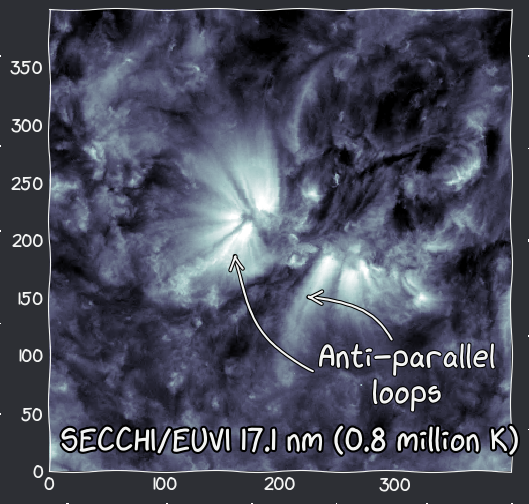

In [52]:
with plt.style.context(ms_dm_style_anim):
    fig, ax_im = plt.subplots(figsize=(6,6))
    ax_im.imshow(secchi_map_cutout_data[:,:,0],
            origin="lower",
            cmap="bone",
            interpolation="none",
            norm=ImageNormalize(
                vmin=np.nanpercentile(secchi_map_cutout_data[:,:,0], 1),
                vmax=np.nanpercentile(secchi_map_cutout_data[:,:,0], 99.9),
                stretch=AsinhStretch(0.05),
            ))
    
    annot_apl_1 = ax_im.annotate("Anti-parallel\nloops", xy=(220, 150),
        xytext=(310, 80), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
        ),
        va="center", ha="center", fontsize=24,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
        alpha=1)
    
    annot_apl_2 = ax_im.annotate("Anti-parallel\nloops", xy=(160, 190),
        xytext=(310, 80), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=-0.5",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]),
        va="center", ha="center", fontsize=24, alpha=0)

    ax_im.text(10, 10, "SECCHI/EUVI 17.1 nm (0.8 million K)", fontsize=24, va="bottom", ha="left",
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    plt.show()
    plt.close()

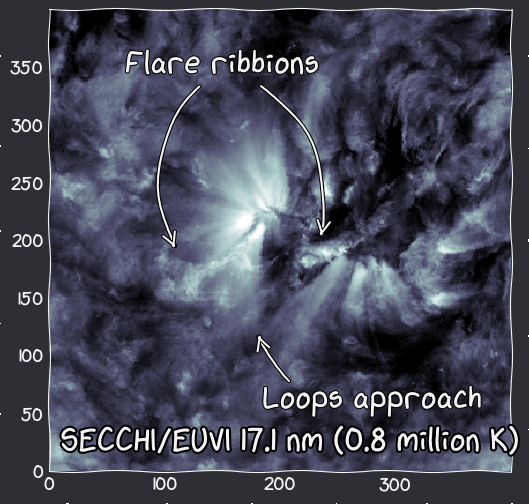

In [53]:
with plt.style.context(ms_dm_style_anim):
    plt.close("all")
    fig, ax_im = plt.subplots(figsize=(6,6))
    ax_im.imshow(secchi_map_cutout_data[:,:,1],
        origin="lower",
        cmap="bone",
        interpolation="none",
        norm=ImageNormalize(
            vmin=np.nanpercentile(secchi_map_cutout_data[:,:,0], 1),
            vmax=np.nanpercentile(secchi_map_cutout_data[:,:,0], 99.9),
            stretch=AsinhStretch(0.05),
        ))
    
    annot_secchi_xpoint = ax_im.annotate("Loops approach", xy=(180, 120),
        xytext=(280, 60), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=-0.4",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
        ),
        va="center", ha="center", fontsize=24,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
        alpha=1)
    
    annot_ribbion_1 = ax_im.annotate("Flare ribbions", xy=(235, 200),
        xytext=(150, 350), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=-0.4",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
        ),
        va="center", ha="center", fontsize=24,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
        alpha=1)

    annot_ribbion_2 = ax_im.annotate("Flare ribbions", xy=(110, 190),
        xytext=(150, 350), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=0.4",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
        ),
        va="center", ha="center", fontsize=24,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
        alpha=0)

    ax_im.text(10, 10, "SECCHI/EUVI 17.1 nm (0.8 million K)", fontsize=24, va="bottom", ha="left",
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
    plt.show()

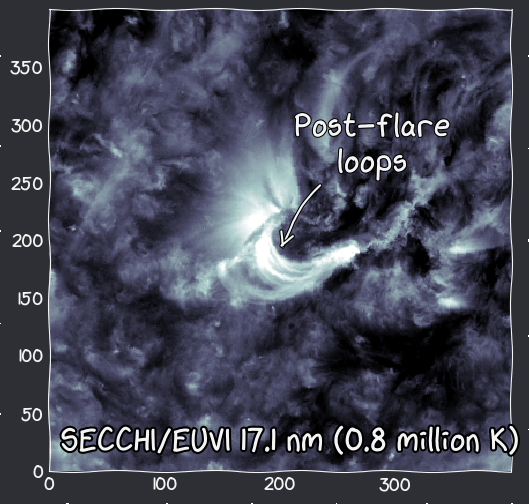

In [54]:
with plt.style.context(ms_dm_style_anim):
    plt.close("all")
    fig, ax_im = plt.subplots(figsize=(6,6))
    ax_im.imshow(secchi_map_cutout_data[:,:,2],
        origin="lower",
        cmap="bone",
        interpolation="none",
        norm=ImageNormalize(
            vmin=np.nanpercentile(secchi_map_cutout_data[:,:,0], 1),
            vmax=np.nanpercentile(secchi_map_cutout_data[:,:,0], 99.9),
            stretch=AsinhStretch(0.05),
        ))
    
    annot_secchi_pfl = ax_im.annotate("Post-flare\nloops", xy=(200, 190),
        xytext=(280, 280), arrowprops=dict(arrowstyle="->",
        connectionstyle="arc3,rad=0.2",facecolor="w", lw=1.5, alpha=1,
        path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()]
        ),
        va="center", ha="center", fontsize=24,
        path_effects=[path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()],
        alpha=1)

    ax_im.text(10, 10, "SECCHI/EUVI 17.1 nm (0.8 million K)", fontsize=24, va="bottom", ha="left",
    path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

    plt.show()

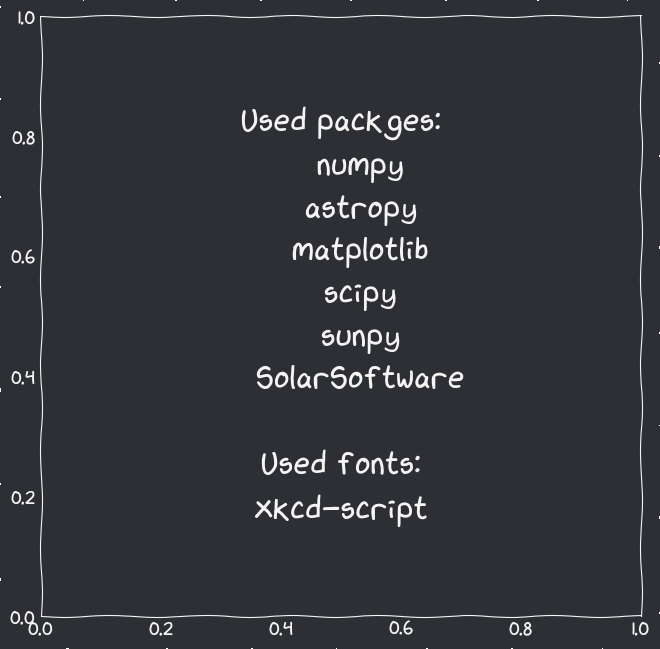

In [62]:
with plt.style.context(ms_dm_style_anim):
    plt.close("all")
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])

    text_used_packages = ax.text(
        0.5, 0.5, 
        "Used packges:\n"
        "    numpy\n"
        "    astropy\n"
        "    matplotlib\n"
        "    scipy\n"
        "    sunpy\n"
        "    SolarSoftware\n"
        "\n"
        "Used fonts:\n"
        "xkcd-script",
        fontsize=24, 
        va="center", ha="center", linespacing=1.5,
    )